<a href="https://colab.research.google.com/github/Antoneva98/portfolio/blob/main/Retail_Performance_Intelligence_User_Behavior%2C_Traffic%2C_and_Product_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install google-cloud-bigquery

# Import data and download dataset

In [ ]:
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import normaltest
from statsmodels.stats.proportion import proportions_ztest


from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
query = """
  SELECT *
  FROM `data-analytics-mate.DA.account`
  LIMIT 5
"""
df = client.query(query).to_dataframe()
df.head()


,id,send_interval,is_verified,is_unsubscribed
0,658133,1,0,0
1,658149,1,0,0
2,658181,1,0,0
3,658197,1,0,0
4,658213,1,0,0


In [ ]:
# creating dataset

query = """
SELECT
  s.date AS order_date,
  o.ga_session_id,

  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.name AS traffic_source_name,
  sp.channel AS traffic_channel,

  acc.id AS account_id,
  acc.is_verified,
  acc.is_unsubscribed,

  p.category,
  p.name AS product_name,
  p.price,
  p.short_description

FROM `data-analytics-mate.DA.order` o
LEFT JOIN `data-analytics-mate.DA.session` s
ON o.ga_session_id = s.ga_session_id

LEFT JOIN `data-analytics-mate.DA.session_params` sp
ON s.ga_session_id = sp.ga_session_id

LEFT JOIN `data-analytics-mate.DA.account_session` acs
ON s.ga_session_id = acs.ga_session_id

LEFT JOIN `data-analytics-mate.DA.account` acc
ON acs.account_id = acc.id

LEFT JOIN `data-analytics-mate.DA.product` p
ON o.item_id = p.item_id
"""

df = client.query(query).to_dataframe()
df.head(-5)


,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source_name,traffic_channel,account_id,is_verified,is_unsubscribed,category,product_name,price,short_description
0,2020-11-06,7799937037,Europe,Slovakia,mobile,Chrome,<Other>,Web,fr,(referral),Paid Search,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
1,2020-11-10,4020421879,Americas,United States,desktop,Chrome,Safari,Macintosh,en,(direct),Direct,653378,1,0,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
2,2020-11-24,6717382496,Americas,United States,desktop,Chrome,Chrome,Web,en-us,(referral),Social Search,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
3,2020-11-26,2093497337,Americas,United States,desktop,Chrome,Chrome,Web,en-us,(direct),Direct,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
4,2020-12-03,9506718330,Europe,Spain,desktop,Chrome,ChromeBook,<Other>,en-us,(referral),Paid Search,<NA>,<NA>,<NA>,Children's furniture,TROFAST,5.0,"Lid, 20x28 cm"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33528,2020-12-06,4201739208,Europe,Germany,desktop,Chrome,Chrome,Web,en-us,<Other>,Paid Search,<NA>,<NA>,<NA>,Tables & desks,LINNMON / LALLE,385.0,"Table, 120x60 cm"
33529,2020-12-17,828176410,Americas,United States,mobile,Safari,iPhone,iOS,en-us,(direct),Direct,<NA>,<NA>,<NA>,Tables & desks,LINNMON / LALLE,385.0,"Table, 120x60 cm"
33530,2020-12-18,9250932017,Americas,United States,mobile,Android Webview,<Other>,Android,en-us,(direct),Direct,<NA>,<NA>,<NA>,Tables & desks,LINNMON / LALLE,385.0,"Table, 120x60 cm"
33531,2020-12-25,6258336614,Asia,South Korea,desktop,<Other>,<Other>,Web,en-us,(referral),Paid Search,<NA>,<NA>,<NA>,Tables & desks,LINNMON / LALLE,385.0,"Table, 120x60 cm"


# Exploratory data analisis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33538 entries, 0 to 33537
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_date           33538 non-null  dbdate 
 1   ga_session_id        33538 non-null  Int64  
 2   continent            33538 non-null  object 
 3   country              33538 non-null  object 
 4   device               33538 non-null  object 
 5   browser              33538 non-null  object 
 6   mobile_model_name    33538 non-null  object 
 7   operating_system     33538 non-null  object 
 8   language             22531 non-null  object 
 9   traffic_source_name  33538 non-null  object 
 10  traffic_channel      33538 non-null  object 
 11  account_id           2781 non-null   Int64  
 12  is_verified          2781 non-null   Int64  
 13  is_unsubscribed      2781 non-null   Int64  
 14  category             33538 non-null  object 
 15  product_name         33538 non-null 

In [ ]:
df.describe()

,ga_session_id,account_id,is_verified,is_unsubscribed,price
count,33538.0,2781.0,2781.0,2781.0,33538.000000
mean,4964900683.146312,658815.525351,0.71521,0.160734,953.298679
std,2884281407.544152,13140.190977,0.451395,0.367351,1317.001775
min,330355.0,636138.0,0.0,0.0,3.000000
25%,2476893918.0,647432.0,0.0,0.0,170.000000
50%,4961245290.0,658322.0,1.0,0.0,445.000000
75%,7442296865.75,670218.0,1.0,0.0,1195.000000
max,9999754183.0,681955.0,1.0,1.0,9585.000000


In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
print(df['order_date'].isna().sum())

0


In [ ]:
print(f"Total number of columns: {df.shape[1]}")

numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
print(f"Number of numeric columns: {len(numeric_cols)}")
print(f"Numeric columns: {numeric_cols}")

categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"Number of categorical columns: {len(categorical_cols)}")
print(f"Categorical columns: {categorical_cols}")

datetime_cols = df.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns.tolist()
print(f"Number of datetime columns: {len(datetime_cols)}")
print(f"Datetime columns: {datetime_cols}")

if "ga_session_id" in df.columns:
  unique_session = df["ga_session_id"].nunique()
  print(f"Number of unique session: {unique_session}")
else:
  print("Column 'ga_session_id' is missing in dataset.")


start_date = df["order_date"].min()
end_date = df["order_date"].max()

print(f"The data covers the period from {start_date.date()} по {end_date.date()}")

Total number of columns: 18
Number of numeric columns: 5
Numeric columns: ['ga_session_id', 'account_id', 'is_verified', 'is_unsubscribed', 'price']
Number of categorical columns: 12
Categorical columns: ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'traffic_source_name', 'traffic_channel', 'category', 'product_name', 'short_description']
Number of datetime columns: 1
Datetime columns: ['order_date']
Number of unique session: 33538
The data covers the period from 2020-11-01 по 2021-01-27


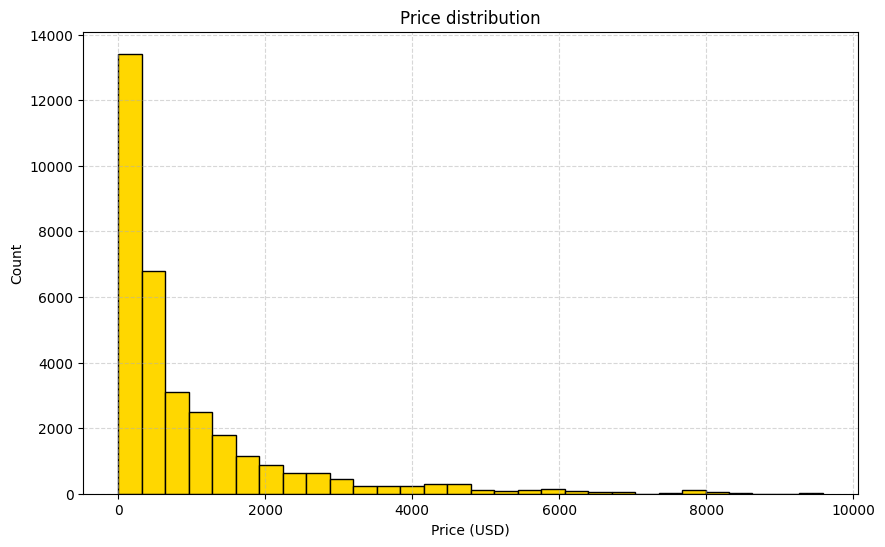

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["price"], color="gold", bins=30, edgecolor="black")
plt.title("Price distribution")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

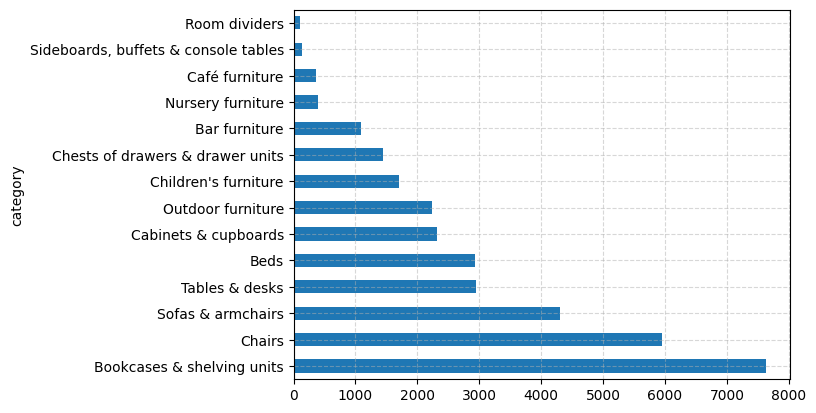

In [ ]:
df["category"].value_counts().plot(kind="barh")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

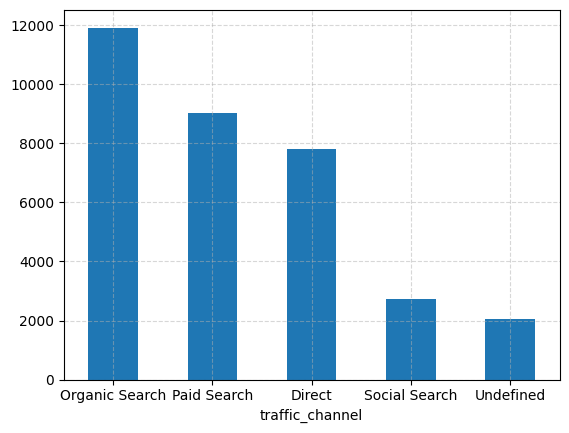

In [ ]:
df["traffic_channel"].value_counts().plot(kind="bar")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.show()

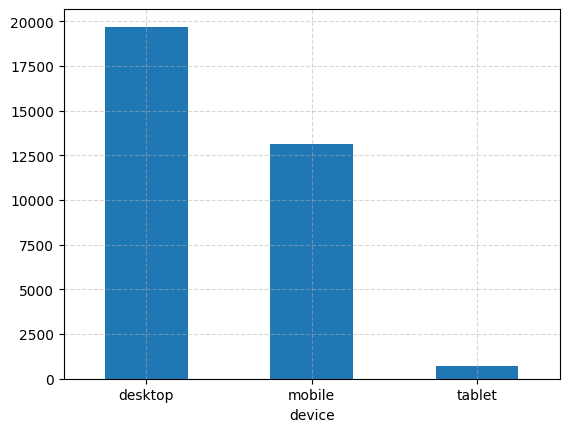

In [ ]:
df["device"].value_counts().plot(kind="bar")
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#Data Quality Check

In [ ]:
print(df.isna().sum()/df.shape[0] * 100)

order_date              0.000000
ga_session_id           0.000000
continent               0.000000
country                 0.000000
device                  0.000000
browser                 0.000000
mobile_model_name       0.000000
operating_system        0.000000
language               32.819488
traffic_source_name     0.000000
traffic_channel         0.000000
account_id             91.707913
is_verified            91.707913
is_unsubscribed        91.707913
category                0.000000
product_name            0.000000
price                   0.000000
short_description       0.000000
dtype: float64


## Conclusion

I consider it appropriate to leave the missing values in "*account_id, is_verified, is_unsubscribed*". These omissions are not an error, but a reflection of user behavior.  
Fields in "*language*" can be left. It depends on the analytical goal.
Deleting these lines is undesirable because it
Minus a third of the data


In [ ]:
duplicated_rows = df.duplicated()
print(duplicated_rows)
print(duplicated_rows.sum())

0        False
1        False
2        False
3        False
4        False
         ...  
33533    False
33534    False
33535    False
33536    False
33537    False
Length: 33538, dtype: bool
0


###There are no duplicates

#Data Analysis

In [ ]:
device_segmentation = df["device"].value_counts()
print(device_segmentation)

device
desktop    19702
mobile     13113
tablet       723
Name: count, dtype: int64


In [ ]:
# Group by 'device' and the date column, and calculate the sum of 'price' for each group
time_series_date = df.groupby(["device", "order_date"])["price"].sum().reset_index()
time_series_date.head()

,device,order_date,price
0,desktop,2020-11-01,144445.0
1,desktop,2020-11-02,206727.3
2,desktop,2020-11-03,304473.8
3,desktop,2020-11-04,212227.7
4,desktop,2020-11-05,249682.0


# Analytical task
###1. Analysis of sales by types and models of devices (in% of total sales)

In [ ]:
total_sales = df["price"].sum()

device_sales = df.groupby("device")["price"].sum().reset_index()
device_sales["percent"] = 100 * device_sales["price"] / total_sales

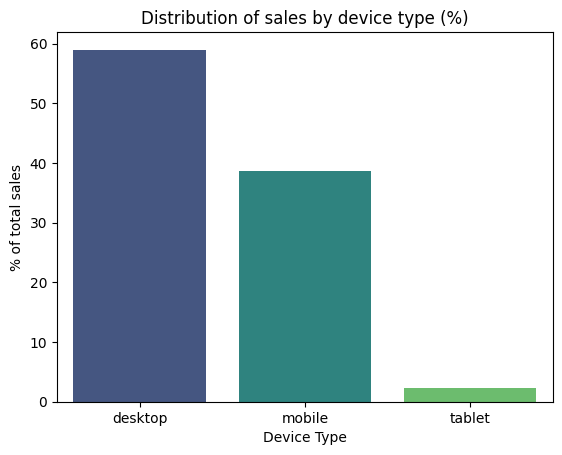

In [ ]:
sns.barplot(data=device_sales, x="device", y="percent", hue="device", palette="viridis")
plt.title("Distribution of sales by device type (%)")
plt.ylabel("% of total sales")
plt.xlabel("Device Type")
plt.show()

###2. Sales by traffic source (% of total sales)

In [ ]:
traffic_sales = df.groupby("traffic_channel")["price"].sum().reset_index()
traffic_sales["percent"] = 100 * traffic_sales["price"] / total_sales

Text(0.5, 1.0, 'Distribution of sales by traffic channel (%)')

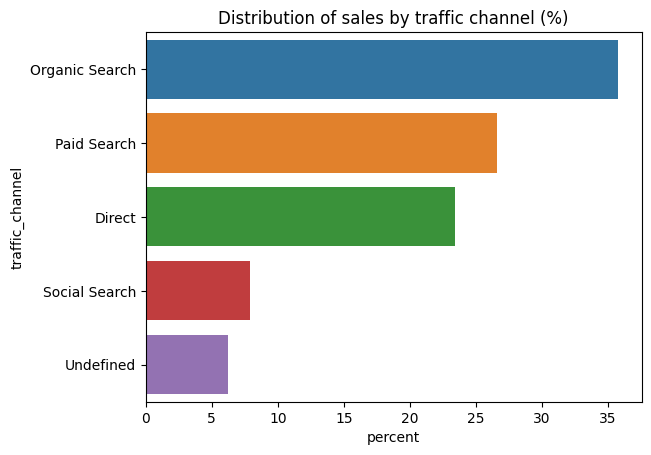

In [ ]:
sns.barplot(data=traffic_sales.sort_values("percent", ascending=False), x="percent", y="traffic_channel", hue="traffic_channel")
plt.title("Distribution of sales by traffic channel (%)")

###3. Is the behavior (sales) different between signed and unsubscribed from the newsletter?

In [ ]:
sub_grouped = df.groupby("is_unsubscribed").agg(
    total_sales=("price", "sum"),
    avg_price=("price", "mean"),
    order_count=("ga_session_id", "count")
).reset_index()
print(sub_grouped)

   is_unsubscribed  total_sales   avg_price  order_count
0                0    2150796.9  921.506812         2334
1                1     431721.6  965.820134          447


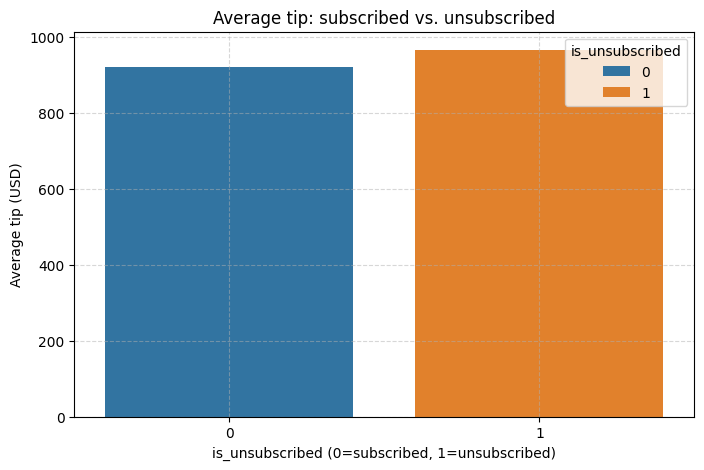

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=sub_grouped, x="is_unsubscribed", y="avg_price", hue="is_unsubscribed")
plt.title("Average tip: subscribed vs. unsubscribed")
plt.xlabel("is_unsubscribed (0=subscribed, 1=unsubscribed)")
plt.ylabel("Average tip (USD)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Normal Distribution Tests: check it statistically

sub_0 = df[df["is_unsubscribed"] == 0]["price"]
sub_1 = df[df["is_unsubscribed"] == 1]["price"]

stat_0, p_0 = normaltest(sub_0)
stat_1, p_1 = normaltest(sub_1)

print(f"D'Agostino-Pearson for subscribed: p_value={p_0:.6e}")
print(f"D'Agostino-Pearson for unsubscribed: p_value={p_1:.6e}")

D'Agostino-Pearson for subscribed: p_value=7.781274e-299
D'Agostino-Pearson for unsubscribed: p_value=5.809081e-59


Для перевірки нормальності розподілу беремо саме тест Д`Агостіно-Пірсона, тому що мибірка досить велика.
Як результат, p-value значно менше ніж 0.05, отже ми можемо відкинути нульову гіпотезу про нормальність розподілу, краще використати непараметричні тести.
Оскільки дані не є нормальними, і ми порівнюємо дві незалежні вибірки, обираємо тест Манна-Уітні.

In [ ]:
stat, p_value = mannwhitneyu(sub_0, sub_1)
print(f"Mann–Whitney test: p-value = {p_value:.4f}")

Mann–Whitney test: p-value = 0.1678


Отримали p-value = 0.1678 > 0.05, це означає, що немає достатніх підстав відхилити нульову гіпотезу.  
Тобто ми не бачимо статистично значущої різниці у продажах між підписаними та відписаними від розсилки.

# 1. Analysis of device effectiveness and user behavior by product category

    device  total_sales    avg_price  order_count
0  desktop   18864039.0   957.468227        19702
1   mobile   12384225.8   944.423534        13113
2   tablet     723466.3  1000.644952          723


<ipython-input-37-233230a5996e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=device_df, x="device", y="total_sales", palette="viridis")


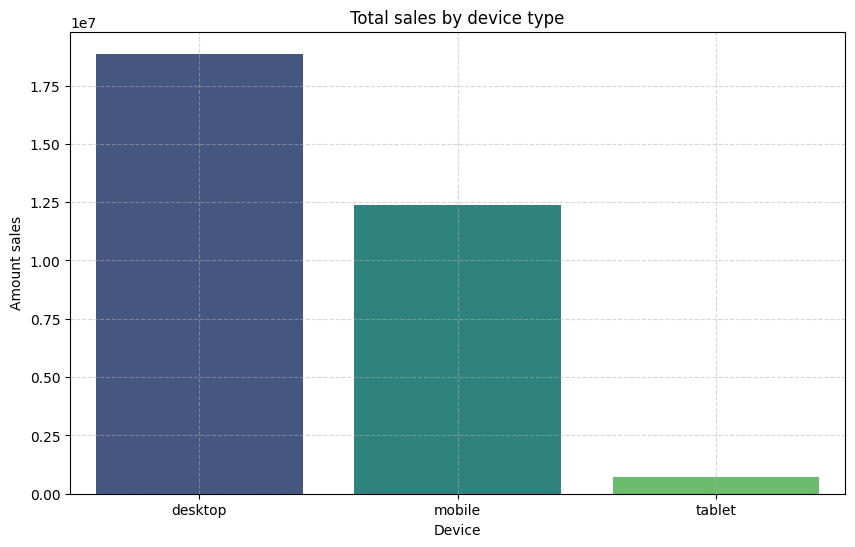

In [ ]:
# group by devices
device_df = df.groupby("device").agg(
    total_sales=("price", "sum"),
    avg_price=("price", "mean"),
    order_count=("ga_session_id", "count")
).sort_values("total_sales", ascending=False).reset_index()

print(device_df)

# visuasisation
plt.figure(figsize=(10, 6))
sns.barplot(data=device_df, x="device", y="total_sales", palette="viridis")
plt.title("Total sales by device type")
plt.xlabel("Device")
plt.ylabel("Amount sales")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Kruskal-Wallis test

device_groups = [group["price"].values for name, group in df.groupby("device")]

stat, p_value = kruskal(*device_groups)
print(f"Kruskal-Wallis test: p-value = {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("There is a statistically significant difference between at least two devices.")
else:
    print("There is no statistically significant difference between at least two devices.")

Kruskal-Wallis test: p-value = 0.1228
There is no statistically significant difference between at least two devices.


Cтатистично значущих відмінностей у цінах замовлень між різними типами пристроїв не виявлено.

<ipython-input-39-412e461d044f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x="total_sales", y="category", palette="viridis")


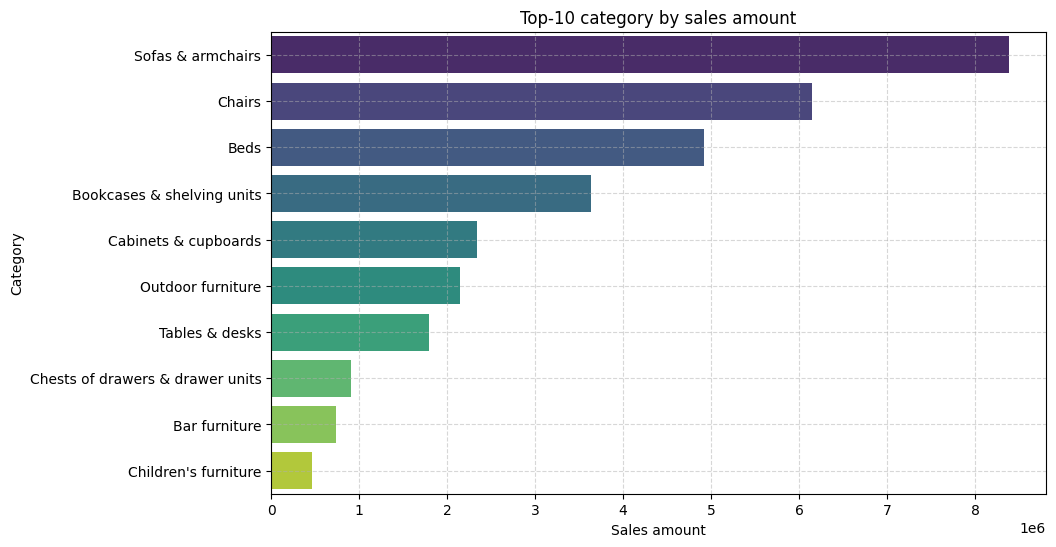

In [ ]:
# Analysis of product categories
cat_df = df.groupby("category").agg(
    total_sales=("price", "sum"),
    avg_price=("price", "mean"),
    order_count=("ga_session_id", "count")
).sort_values("total_sales", ascending=False).reset_index()

top_10 = cat_df.head(10)

# visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10, x="total_sales", y="category", palette="viridis")
plt.title("Top-10 category by sales amount")
plt.xlabel("Sales amount")
plt.ylabel("Category")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 2. Conversions by device type

In [ ]:
df["made_order"] = df["price"].notna().astype(int)

# group by device type
conversion_by_device = df.groupby("device").agg(
    total_session=("ga_session_id", "nunique"),
    sessions_with_orders=("made_order", "sum")
).reset_index()

# conversion rate
conversion_by_device["conversion_rate"] = 100 * conversion_by_device["sessions_with_orders"] / conversion_by_device["total_session"]
print(conversion_by_device.sort_values(by='conversion_rate', ascending=False))

    device  total_session  sessions_with_orders  conversion_rate
0  desktop          19702                 19702            100.0
1   mobile          13113                 13113            100.0
2   tablet            723                   723            100.0


# 3. Analysis of sales dynamics by traffic and devices

Sales dynamics by traffic channels


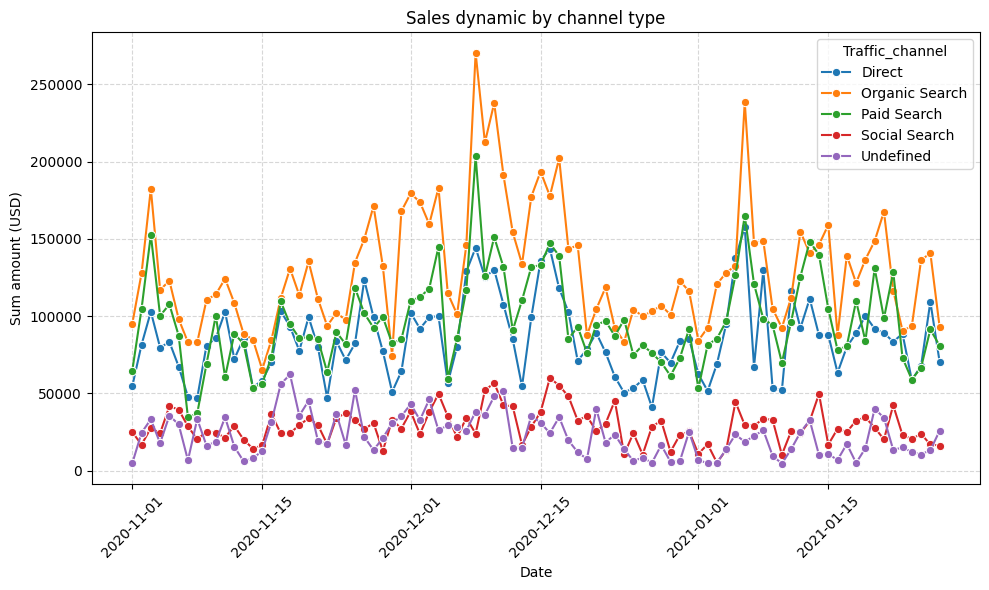

In [ ]:
# aggregate sales by date and channel type
sales_device = df.groupby(["order_date", "traffic_channel"])["price"].sum().reset_index()

# visualisation
plt.figure(figsize=(10, 6))
sns.lineplot(data=sales_device, x="order_date", y="price", hue="traffic_channel", marker="o")

plt.title("Sales dynamic by channel type")
plt.xlabel("Date")
plt.ylabel("Sum amount (USD)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Traffic_channel")
plt.tight_layout()
plt.show()

Графік охоплює період з початку листопада 2020 року до середини січня 2021 року.
Продажі по всіх каналах демонструють сезонність. Спостерігаються піки продажів приблизно на початку грудня та на початку січня, що може вказувати на передноворічні/різдвяні свята або акційні періоди.


Organic Search (Органічний пошук) є основним каналом продажів.
Direct (Прям) та Paid Search (Платний пошук) також є значним джерелом доходу, але, як правило, вони нижчі.


Sales dynamics by device type

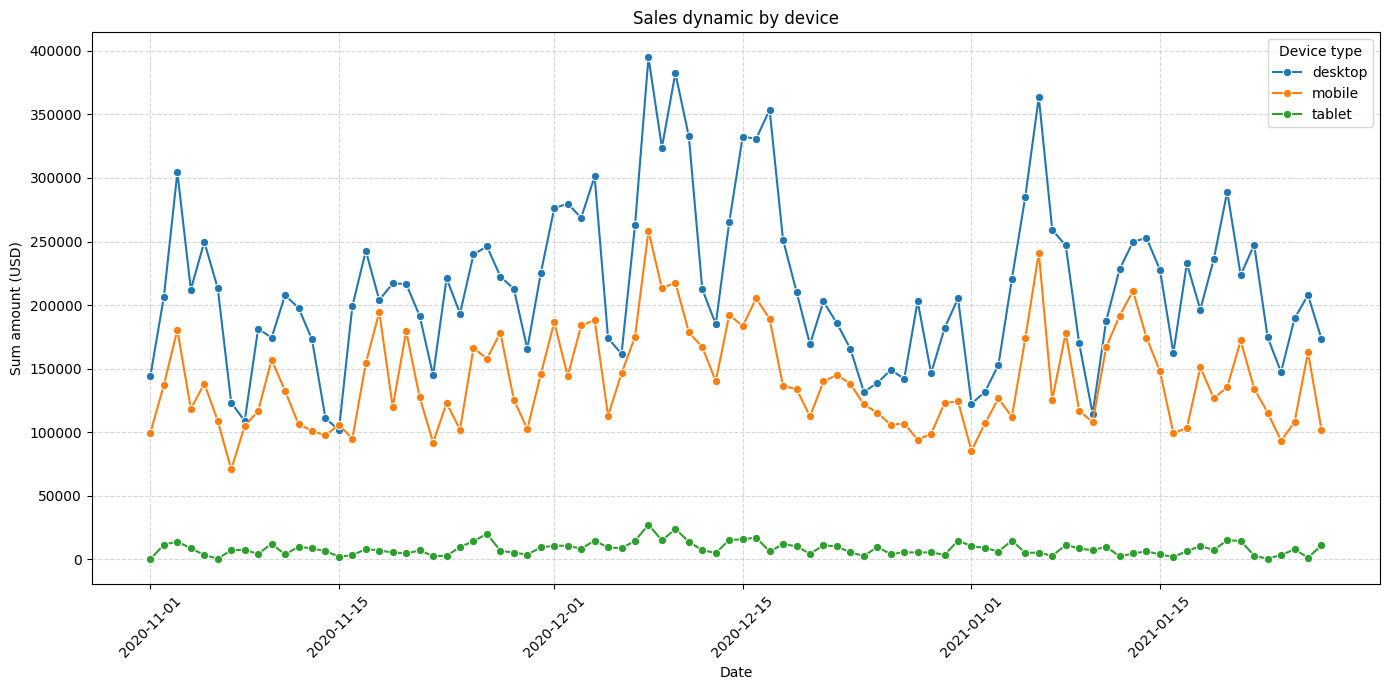

In [ ]:
# aggregate sales by date and device type
sales_device = df.groupby(["order_date", "device"])["price"].sum().reset_index()

# visualisation
plt.figure(figsize=(14, 7))
sns.lineplot(data=sales_device, x="order_date", y="price", hue="device", marker="o")

plt.title("Sales dynamic by device")
plt.xlabel("Date")
plt.ylabel("Sum amount (USD)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Device type")
plt.tight_layout()
plt.show()

Desktop (синя лінія) генерує найбільше продажів протягом усього періоду. Піки та спади повторюють статистику продажів за каналами трафіку.
Mobile (помаранчева лінія) займає друге місце за обсягом продажів. Також показує значні коливання, але його продажі значно нижчі, ніж у десктопу.
Tablet (зелена лінія) показує дуже низькі обсяги продажів, майже на нульовому рівні, і його внесок у загальний дохід є мінімальним.

Спостерігаються значні сплески продажів для Desktop та Mobile на початку грудня та на початку січня. Це дуже схоже на святкові сезони (наприклад, передноворічні розпродажі, "Чорна п'ятниця" та інші акційні преіоди), коли люди активно купують онлайн.
Порівняння з іншим графіком:

Якщо порівнювати цей графік з попереднім "Sales dynamic by channel type" (що охоплює той самий період), то можна припустити, що піки продажів у каналах "Direct" та "Organic Search" можуть бути тісно пов`язані з піковою активністю користувачів саме з Desktop та Mobile пристроїв.


# 4. Pivot table
Total sales (Top 10 categories × Top 5 countries)

In [ ]:
# Top 10 categories in terms of total sales
top_categories = df.groupby("category")["price"].sum().nlargest(10).index

# Top 5 countries in terms of total sales
top_countries = df.groupby("country")["price"].sum().nlargest(5).index

# data filtering
filtered_data = df[df["category"].isin(top_categories) & df["country"].isin(top_countries)]

# pivot table
pivot_table_country = pd.pivot_table(
    filtered_data,
    values="price",
    index="category",
    columns="country",
    aggfunc="sum",
    fill_value=0
).round(2)

pivot_table_country

country,Canada,France,India,United Kingdom,United States
category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


США — абсолютний лідер з виручки:
* Виручка США в кожній категорії в рази перевищує виручку інших країн.
* Наприклад, у категорії "Sofas & armchairs" США згенерували 3.7М, в той час, як друга країна-лідер - Індія з 788К.

Найкращі категорії товарів:
* Sofas & armchairs, Chairs, Beds — найвигідніші категорії в усіх країнах.
* Ці категорії мають високий середній чек і, ймовірно, вищий попит.

Sales dynamics for the top 5 devices (device types × dates)

In [ ]:
# Top 10 devices in terms of total sales
top_devices = df.groupby("device")["price"].sum().nlargest(5).index

# data filtering

filtered_dev = df[df["device"].isin(top_devices)]

# pivot_table
pivot_device_date = pd.pivot_table(
    filtered_dev,
    values="price",
    index="order_date",
    columns="device",
    aggfunc="sum",
    fill_value=0
).round(2)

pivot_device_date

device,desktop,mobile,tablet
order_date,,,
2020-11-01,144445.0,99698.5,149.0
2020-11-02,206727.3,137269.5,11510.0
2020-11-03,304473.8,180602.8,13903.0
2020-11-04,212227.7,118324.4,8635.0
2020-11-05,249682.0,138256.0,3338.6
...,...,...,...
2021-01-23,174769.3,115462.2,374.0
2021-01-24,147218.2,93233.2,3367.0
2021-01-25,189441.7,107902.6,7745.0


Desktop - головний прибутковий канал.
Mobile також значущий.

Share of purchases by signed users (is_verified) by category

In [ ]:
# Filtering only on users with account_id
df_verified = df[df["account_id"].notna()]

# pivot table: total sales by category among verified/unverified
pivot_verified_category = pd.pivot_table(
    df_verified,
    values="price",
    index="category",
    columns="is_verified",
    aggfunc="sum",
    fill_value=0
).rename(columns={0: "Unverified", 1: "Verified"}).round(2)

pivot_verified_category["Verified Share (%)"] = (
    100 * pivot_verified_category["Verified"] /
    (pivot_verified_category["Verified"] + pivot_verified_category["Unverified"])
).round(2)

pivot_verified_category.sort_values("Verified Share (%)", ascending=False)

is_verified,Unverified,Verified,Verified Share (%)
category,,,
"Sideboards, buffets & console tables",1410.0,8795.0,86.18
Chests of drawers & drawer units,11604.0,46384.0,79.99
Tables & desks,34987.0,118546.0,77.21
Nursery furniture,1909.0,5770.0,75.14
Sofas & armchairs,168234.0,492222.0,74.53
Bar furniture,13254.0,37760.0,74.02
Cabinets & cupboards,58241.0,157628.5,73.02
Chairs,147583.6,392372.6,72.67
Bookcases & shelving units,75304.8,200204.8,72.67


Висновки:  
	1.	Більшість доходу йде від Verified акаунтів — понад 70% у більшості категорій.  
	2.	Неверифіковані акаунти - також вагомий сегмент, особливо для Outdoor, Beds, Cafe furniture.

# 5. Statistical analysis of relationships

Correlation between sales in the top 5 product categories

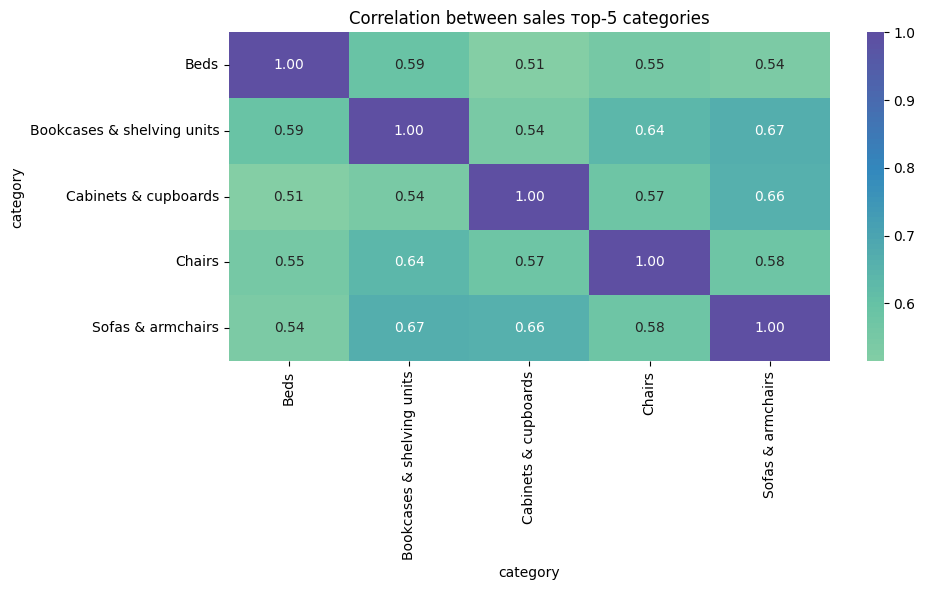

Sofas & armchairs vs Chairs: p-value = 3.638833e-09, correlation = 0.58
Sofas & armchairs vs Beds: p-value = 7.687333e-08, correlation = 0.54
Sofas & armchairs vs Bookcases & shelving units: p-value = 1.406972e-12, correlation = 0.67
Sofas & armchairs vs Cabinets & cupboards: p-value = 3.415056e-12, correlation = 0.66
Chairs vs Sofas & armchairs: p-value = 3.638833e-09, correlation = 0.58
Chairs vs Beds: p-value = 2.079183e-08, correlation = 0.55
Chairs vs Bookcases & shelving units: p-value = 2.504550e-11, correlation = 0.64
Chairs vs Cabinets & cupboards: p-value = 5.465903e-09, correlation = 0.57
Beds vs Sofas & armchairs: p-value = 7.687333e-08, correlation = 0.54
Beds vs Chairs: p-value = 2.079183e-08, correlation = 0.55
Beds vs Bookcases & shelving units: p-value = 1.154998e-09, correlation = 0.59
Beds vs Cabinets & cupboards: p-value = 2.910930e-07, correlation = 0.51
Bookcases & shelving units vs Sofas & armchairs: p-value = 1.406972e-12, correlation = 0.67
Bookcases & shelving

In [ ]:
# Тоp-5 category
top_5_categories = df.groupby("category")["price"].sum().nlargest(5).index

# aggregate sales by date and category
df_filtered = df[df["category"].isin(top_5_categories)]

sales_by_cat_date = df_filtered.pivot_table(
    index="order_date",
    columns="category",
    values="price",
    aggfunc="sum",
    fill_value=0
)

# Correlation
correlation_data = sales_by_cat_date.corr()

# visualisation
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_data, annot=True, cmap="Spectral", center=0, fmt=".2f")
plt.title("Correlation between sales тоp-5 categories")
plt.tight_layout()
plt.show()

# Statistical significance (p-value)
for col1 in top_5_categories:
  for col2 in top_5_categories:
    if col1 != col2:
      corr, p_value = pearsonr(sales_by_cat_date[col1], sales_by_cat_date[col2])
      print(f"{col1} vs {col2}: p-value = {p_value:.6e}, correlation = {corr:.2f}")

Основні висновки:
* Низьке p-value означає статистичну значущість.  
* Найсильніші зв`язки:  
 * Sofas & armchairs ↔ Bookcases & shelving units (0.67)  
 * Sofas & armchairs ↔ Cabinets & cupboards (0.66)  
 * Bookcases & shelving units ↔ Chairs (0.64)  

⸻

Що це означає для бізнесу?
* Продажі в цих категоріях зростають і падають разом.
* Можливо, покупці роблять комплексні покупки меблів, або ці товари мають спільну сезонну залежність.


Correlation by traffic channel

In [ ]:
pivot_channel = pd.pivot_table(
    df,
    values="price",
    index="order_date",
    columns="traffic_channel",
    aggfunc="sum",
    fill_value=0
).sort_index()

In [ ]:
correlation_data = pivot_channel.corr(method="pearson").round(2)

In [ ]:
# column pairs
pairs = list(combinations(pivot_channel.columns, 2)) # we take a function that generates all possible unique combinations of a certain length from the passed list

for a, b in pairs:
    corr, pval = pearsonr(pivot_channel[a], pivot_channel[b])
    print(f"{a} vs {b}: correlation = {corr:.2f}, p-value = {pval:.6e}")

Direct vs Organic Search: correlation = 0.76, p-value = 9.107881e-18
Direct vs Paid Search: correlation = 0.72, p-value = 1.512880e-15
Direct vs Social Search: correlation = 0.46, p-value = 5.901047e-06
Direct vs Undefined: correlation = 0.42, p-value = 3.838547e-05
Organic Search vs Paid Search: correlation = 0.81, p-value = 1.755643e-21
Organic Search vs Social Search: correlation = 0.43, p-value = 2.347593e-05
Organic Search vs Undefined: correlation = 0.44, p-value = 2.237821e-05
Paid Search vs Social Search: correlation = 0.45, p-value = 9.696038e-06
Paid Search vs Undefined: correlation = 0.43, p-value = 2.897496e-05
Social Search vs Undefined: correlation = 0.36, p-value = 5.853111e-04


Усі зв`язки статистично значущі (p-value < 0.05)
* Найсильніші кореляції:
 * Organic Search ↔ Paid Search (r = 0.81)
 * Direct ↔ Organic Search (r = 0.76)
 * Direct ↔ Paid Search (r = 0.72)

Analysis of sales and number of orders by day of the week and season

In [ ]:
# add columns for day of the week, month, and season
df["day_of_week"] = df["order_date"].dt.day_name()
df["month"] = df["order_date"].dt.month

In [ ]:
# define unique months to simplify the writing of the function
df["month"].unique()

array([11, 12,  1], dtype=int32)

In [ ]:
# function to determine the season by month
def get_season(month):
  if month in [12, 1]:
    return "Winter"
  else:
    return "Autumn"

df["season"] = df["month"].apply(get_season)

# aggregate data for analysis - sales amount and number of orders by day of the week
day_summary = df.groupby("day_of_week").agg(
    total_revenue=pd.NamedAgg(column="price", aggfunc="sum"), # using a way to specify the name of the new column and the aggregation function that we apply to a specific column
    order_count=pd.NamedAgg(column="ga_session_id", aggfunc="count")
).reset_index()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# make the day_of_week column a categorical column with the specified order
day_summary["day_of_week"] = pd.Categorical(day_summary["day_of_week"], categories=day_order, ordered=True)
day_summary = day_summary.sort_values("day_of_week")

# aggregate data for analysis - sales amount and number of orders by season
season_summary = df.groupby("season").agg(
    total_revenue=pd.NamedAgg(column="price", aggfunc="sum"),
    order_count=pd.NamedAgg(column="ga_session_id", aggfunc="count")
).reset_index()


print("Analysis by day of the week:")
print(day_summary)

print("\nAnalysis by season:")
print(season_summary)

Analysis by day of the week:
  day_of_week  total_revenue  order_count
1      Monday      4636290.4         4962
5     Tuesday      5457515.9         5763
6   Wednesday      5466542.9         5614
4    Thursday      4936935.6         5015
0      Friday      4523067.2         4586
2    Saturday      3477990.9         3724
3      Sunday      3473388.2         3874

Analysis by season:
   season  total_revenue  order_count
0  Autumn      9897515.0        10540
1  Winter     22074216.1        22998


#6. Statistical analysis of differences between groups
Analyze the sales for each date of registered and unregistered users. Create appropriate samples, analyze the distributions of the data in both samples. Choose an appropriate statistical test to compare the samples. Draw a conclusion about the statistical significance of the results.


In [ ]:
 #1. sample preparation
 df["order_date"] = pd.to_datetime(df["order_date"])
 df_registered = df[df["account_id"].notna()]
 df_anonym = df[df["account_id"].isna()]

In [ ]:
#2. aggregation: Amount of sales by date
reg_daily = df_registered.groupby("order_date")["price"].sum().reset_index()
reg_daily.rename(columns={"price": "registered_sales"}, inplace=True)

anon_daily = df_anonym.groupby("order_date")["price"].sum().reset_index()
anon_daily.rename(columns={"price": "anonym_sales"}, inplace=True)

# combinate both dataframes for comparison
daily_sales = pd.merge(reg_daily, anon_daily, on="order_date", how="outer").fillna(0)

In [ ]:
#4. Normaltest (Shapiro-Wilk)
shapiro_registered = shapiro(daily_sales["registered_sales"])
shapiro_anonym = shapiro(daily_sales["anonym_sales"])

print("Shapiro Registered:", shapiro_registered)
print("Shapiro Anonym:", shapiro_anonym)

Shapiro Registered: ShapiroResult(statistic=np.float64(0.9591810175035426), pvalue=np.float64(0.007295139880540744))
Shapiro Anonym: ShapiroResult(statistic=np.float64(0.9521579282190968), pvalue=np.float64(0.0026183359245325936))


p-значення менше 0.05 - не можемо провести t-test, та відкидаємо гіпотезу про нормальність.
Отже, у нас є дві вибірки з ненормальним розподілом.
Оскільки розподіли не нормальні, варто застосувати непараметричний тест.

Mann-Whitney тест - для порівняння рангів продажів між зареєстрованими та незареєстрованими.


In [ ]:
#5. Mann-Whitney test

registered = df[df['account_id'].notna()]['price']
anonym = df[df['account_id'].isna()]['price']

stat, p = mannwhitneyu(registered, anonym, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat}")
print(f"P-value: {p}")

# interpretation
alpha = 0.05
if p < alpha:
    print("The result is statistically significant: there are differences between the groups")
else:
    print("No statistically significant differences between groups")

Mann-Whitney U statistic: 41771375.0
P-value: 0.041590896614016215
The result is statistically significant: there are differences between the groups


Comparison of the share of sessions with organic traffic in Europe and America

In [ ]:
# find unique meanings of continent
print(df["continent"].unique())

# find unique values of traffic_source_name
print(df["traffic_source_name"].unique())

# check if there is organic traffic in America
print(df[(df["continent"].str.contains("America", case=False, na=False)) & (df["traffic_source_name"].str.contains("Organic", case=False, na=False))])

['Europe' 'Americas' 'Oceania' 'Asia' 'Africa' '(not set)']
['(referral)' '(direct)' '<Other>' '(organic)' '(data deleted)']
      order_date  ga_session_id continent        country   device  browser  \
9     2020-12-19     6224067015  Americas  United States  desktop     Edge   
10    2020-12-22     8032498843  Americas  United States   mobile   Chrome   
12    2021-01-03     9036959191  Americas           Peru  desktop  Firefox   
17    2021-01-10      951341942  Americas         Brazil  desktop   Chrome   
23    2020-11-02     6897411806  Americas  United States  desktop  <Other>   
...          ...            ...       ...            ...      ...      ...   
33491 2020-11-01     5041302343  Americas        Ecuador  desktop   Chrome   
33504 2020-11-01     6260592731  Americas  United States   mobile   Chrome   
33506 2020-11-01     1329291455  Americas  United States  desktop   Chrome   
33519 2020-12-31     9885191843  Americas         Canada  desktop   Safari   
33523 2020-11-10 

In [ ]:
# number of organic sessions in Europe
organic_sessions_europe = df[(df["continent"] == "Europe") & (df["traffic_source_name"] == "(organic)")]["ga_session_id"].nunique()

#number of organic sessions in America
organic_sessions_america = df[(df["continent"] == "Americas") & (df["traffic_source_name"] == "(organic)")]["ga_session_id"].nunique()

# total number of sessions in Europe
total_sessions_europe = df[df["continent"] == "Europe"]["ga_session_id"].nunique()

# total number of sessions in America
total_sessions_america = df[df["continent"] == "Americas"]["ga_session_id"].nunique()

print(f"Organic sessions Europe: {organic_sessions_europe}")
print(f"Organic sessions America: {organic_sessions_america}")
print(f"Total sessions Europe: {total_sessions_europe}")
print(f"Total sessions America: {total_sessions_america}")

Organic sessions Europe: 2147
Organic sessions America: 6290
Total sessions Europe: 6261
Total sessions America: 18553


In [ ]:
count = np.array([organic_sessions_europe, organic_sessions_america])
nobs = np.array([total_sessions_europe, total_sessions_america])

stat, pval = proportions_ztest(count, nobs)
print(f"Z-test statistic={stat:.4f}, p-value={pval:.4f}")

Z-test statistic=0.5615, p-value=0.5744


Нульова гіпотеза: частка органічного трафіку в Європі та Америці однакова.
Альтернативна гіпотеза: частки відрізняються.

Оскільки p-value > 0.05, ми не маємо підстав відхиляти нульову гіпотезу. Тобто,pізниця в частці органічного трафіку між Європою та Америкою статистично незначуща.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

df.to_csv('Portfolio_Project_1.csv', index=False)
files.download('Portfolio_Project_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Link to dashboard

https://public.tableau.com/views/PortfolioProject1_17485537077930/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link